In [596]:
import csv
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import molmass
from adjustText import adjust_text

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import HuberRegressor, LinearRegression

In [273]:
data = pd.read_csv('../data/processed/lipidomics_linregress_normalized_data.csv')
data.rename({'Quant Ion': 'm/z', 
             'Retention Time (min)': 'RT [min]',
             'Area (max)': 'Area (Max.)'}, inplace=True, axis=1)
lipids = data.to_dict(orient='index')
lipids[0]

{'RT [min]': 0.523,
 'm/z': 498.05923,
 'Polarity': '+',
 'Area (Max.)': 22.897356791749868,
 'Identification': nan,
 'Lipid Class': nan,
 'Features Found': 29,
 '20210729_AJ_Toh_RatBloodGlucose_ExtractionBlank.raw (F1)': 12.798713046766716,
 '20210729_AJ_Toh_RatBloodGlucose_SolventBlank.raw (F2)': 14.241491112448028,
 '20210729_AJ_Toh_RatBloodGlucose_T1062M_20210329_9wk_FBG_QC1.raw (F11)': 21.104892279788825,
 '20210729_AJ_Toh_RatBloodGlucose_T1062M_20210329_9wk_FBG_QC3.raw (F13)': 21.10414772250176,
 '20210729_AJ_Toh_RatBloodGlucose_Water_R1.raw (F65)': 13.040385790801333,
 '20210729_AJ_Toh_RatBloodGlucose_Water_R2.raw (F66)': 13.019622707743515,
 '20210729_AJ_Toh_RatBloodGlucose_Water_R3.raw (F67)': 12.930029832422758,
 '20210729_AJ_Toh_RatBloodGlucose_T1076M_20210405_10wk_FBG.raw (F27)': 20.94356354826733,
 '20210729_AJ_Toh_RatBloodGlucose_T1062M_20210322_8wk_FBG.raw (F9)': 22.897356791749868,
 '20210729_AJ_Toh_RatBloodGlucose_T1093M_20210402_9wk_FBG.raw (F49)': 21.986093640646505,

In [243]:
data = pd.read_csv('../data/processed/combined_metab_lipid_table.csv')
data['is_id'] = data['Proposed ID'] != 'unknown'

lipids = data.loc[(data['Type'] == 'lipid')]
lipids = data.to_dict(orient='index')
lipids[701]

{'Unique ID': 'unknown_641.1087_0.537',
 'Type': 'lipid',
 'i': 'l_1',
 'Proposed ID': 'unknown',
 'Tracefinder ID': nan,
 'Lipid Class': 'unknown',
 'm/z': 641.1087,
 'RT [min]': 0.537,
 'Area (Max.)': 25.718749637634662,
 'Score': nan,
 'Adduct': nan,
 'Polarity': '+',
 'pval effect of glucose tolerance': 0.921183629173221,
 'pval effect of sampling': 0.926172248987319,
 'pval effect of interaction sampling and glucose tolerance': 0.8075742922593869,
 'fdr corrected pval effect of glucose tolerance': 0.9474875043667456,
 'fdr corrected pval effect of sampling': 0.9375596127043762,
 'fdr corrected pval effect of interaction sampling and glucose tolerance': 0.8887943674834373,
 '1076_10_FBG': 21.53364808261779,
 '1062_8_FBG': 24.58622732014338,
 '1093_9_FBG': 24.375151167931207,
 '1060_8_RBG': 25.685664129507128,
 '1091_10_FBG': 25.422294448505674,
 '1092_9_RBG': 24.93691552713957,
 '1093_10_RBG': 24.77994052998816,
 '1082_10_FBG': 24.696276454672915,
 '1060_9_RBG': 25.054941206017904,

## Searching the metabolite data in CD 3.3 found lots of oxy-fatty acids
# Don't forget to look for Carnitines!
### There might also be some highly unsaturated fatty acids in the data, so look for those too 
### Calculate monoisotopic molecular weight for all ions in the series and check the unidentified features list for these

In [290]:
def ppm_tol(m1, m2, tol=10):
    return abs(m1 - m2) / m1 * 1e6 < tol

def make_fatty_acid(C, unsat, O):
    # O parameter = number of extra oxygens
    # num H's = 2 * C - (2 * unsats)
    # Max. num. of unsats = C/2 - 1
    if unsat > C / 2 - 1:
        raise ValueError('too many unsaturations')
    if O == 0:
        O_text = ''
    elif O == 1:
        O_text = 'O'
    else:
        O_text = f'O{O}'
    formula = 'O2' + (C * 'C') + (2 * C - (2 * unsat)) * 'H' + O_text
#     print(formula)
    f = molmass.Formula(formula)
    return f.isotope.mass, f.formula
            
make_fatty_acid(8, 0, 1)

(160.10994437439, 'C8H16O3')

array([[14.,  0.,  0.],
       [14.,  0.,  0.],
       [14.,  3.,  0.],
       [14.,  3.,  0.],
       [14.,  3.,  0.],
       [14.,  3.,  0.],
       [15.,  0.,  0.],
       [16.,  0.,  0.],
       [16.,  0.,  0.],
       [16.,  0.,  1.],
       [16.,  1.,  0.],
       [16.,  1.,  0.],
       [16.,  2.,  0.],
       [17.,  0.,  0.],
       [17.,  1.,  0.],
       [17.,  4.,  2.],
       [18.,  0.,  0.],
       [18.,  0.,  0.],
       [18.,  0.,  0.],
       [18.,  0.,  1.],
       [18.,  1.,  0.],
       [18.,  2.,  0.],
       [18.,  2.,  0.],
       [18.,  2.,  2.],
       [18.,  3.,  0.],
       [18.,  4.,  0.],
       [18.,  4.,  0.],
       [19.,  0.,  0.],
       [19.,  1.,  0.],
       [19.,  3.,  2.],
       [19.,  3.,  2.],
       [20.,  1.,  0.],
       [20.,  2.,  0.],
       [20.,  3.,  0.],
       [20.,  3.,  0.],
       [20.,  3.,  2.],
       [20.,  3.,  2.],
       [20.,  3.,  2.],
       [20.,  4.,  0.],
       [20.,  5.,  0.],
       [20.,  5.,  0.],
       [20.,  5.

In [443]:
PolynomialFeatures().fit_transform(np.array(training_data)[:, :-1])

array([[1.000e+00, 1.400e+01, 0.000e+00, 0.000e+00, 1.960e+02, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [1.000e+00, 1.400e+01, 0.000e+00, 0.000e+00, 1.960e+02, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [1.000e+00, 1.400e+01, 3.000e+00, 0.000e+00, 1.960e+02, 4.200e+01,
        0.000e+00, 9.000e+00, 0.000e+00, 0.000e+00],
       [1.000e+00, 1.400e+01, 3.000e+00, 0.000e+00, 1.960e+02, 4.200e+01,
        0.000e+00, 9.000e+00, 0.000e+00, 0.000e+00],
       [1.000e+00, 1.400e+01, 3.000e+00, 0.000e+00, 1.960e+02, 4.200e+01,
        0.000e+00, 9.000e+00, 0.000e+00, 0.000e+00],
       [1.000e+00, 1.400e+01, 3.000e+00, 0.000e+00, 1.960e+02, 4.200e+01,
        0.000e+00, 9.000e+00, 0.000e+00, 0.000e+00],
       [1.000e+00, 1.500e+01, 0.000e+00, 0.000e+00, 2.250e+02, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [1.000e+00, 1.600e+01, 0.000e+00, 0.000e+00, 2.560e+02, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+

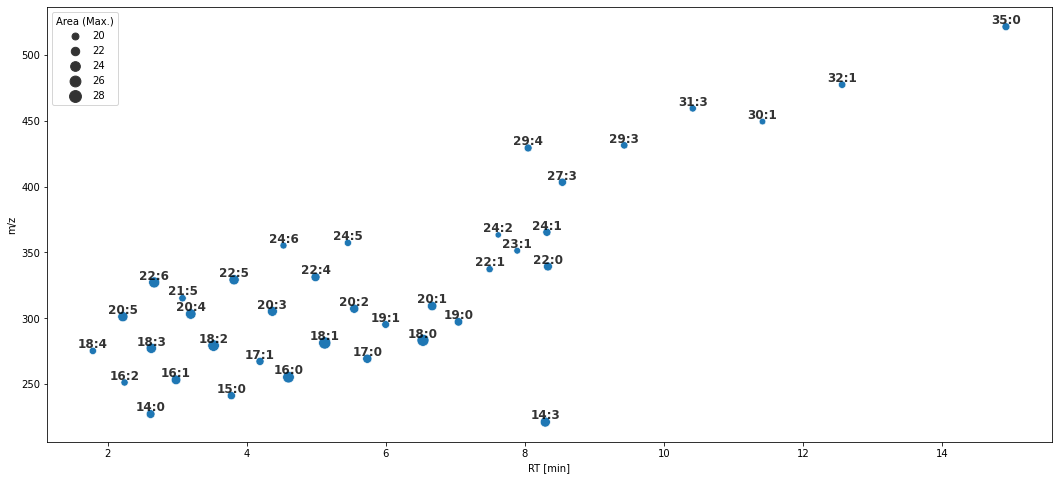

In [574]:
fas = {}
C_range = range(0, 37)
unsat_range = range(0, 10)
O_range = range(0, 1)

y_array = [[[None for O in O_range] for unsat in unsat_range] for C in C_range]
# x_array = [[[O for O in O_range] for unsat in unsat_range] for C in C_range]
training_data = []
fas_list = []
for C in C_range:
    for unsat in unsat_range:
        for O in O_range:
            if O == 0:
                O_text = ''
            elif O == 1:
                O_text = ';O'
            else:
                O_text = f';O{O}'
            fa_name = f'FA {C}:{unsat}' + O_text
            try:  
                mimw, formula = make_fatty_acid(C, unsat, O)
            except ValueError:
                continue
            fas[fa_name] = {'mimw': mimw, 
                            '[M-H]-1': mimw-1.00782503223, 
                            '[M+NH4]+1': mimw+17.02654910112, 
                            'formula': formula,
                            'C': C, 'unsat': unsat, 'O': O}
            fas_list.append([C, unsat, O, mimw-1.00782503223])

result = []
for fa_name, fa in fas.items():
    for i, row in lipids.items():
        if ppm_tol(fa['[M-H]-1'], row['m/z'], tol=7.5) and row['RT [min]'] < 15:
            row['MS1_match_id'] = fa_name
            C, unsat, O = fa['C'], fa['unsat'], fa['O']
            row['C'] = C
            row['unsat'] = unsat
            row['O'] = O
            result.append(row)
            y_array[C][unsat][O] = row['RT [min]']
            training_data.append([C, unsat, O, row['RT [min]'], row['m/z']])
            
df = pd.DataFrame(result)

plot_data = df.drop_duplicates('MS1_match_id')

fig, ax = plt.subplots()
sns.scatterplot(
    data=plot_data,
    x='RT [min]',
    y='m/z',
#     hue='is_id',
#     s=100,
    size='Area (Max.)', sizes=(40, 150),
    ax=ax,
)
# texts = [plt.text(x[i], y[i], 'Text%s' %i, ha='center', va='center') for i in range(len(x))]
texts = []
fas_used = set()
for i, row in plot_data.iterrows():
    fa_text = row['MS1_match_id'][3:]
#     if fa_text in fas_used:
#         continue
    fas_used.add(fa_text)
#     fa_text = fa_text.replace(':', '\n')#.replace(';', '\n')
    texts.append(plt.annotate(
#         s=fa_text, x=row['RT [min]'], y=row['m/z'],
        text=fa_text, xy=(row['RT [min]'], row['m/z']),
        ha='center', va='bottom', size=12, color='black', fontweight='semibold',
        alpha=0.8, 
    ))
# adjust_text(texts, lim=1,
# #             only_move={'points':'y', 'texts':'y'}, 
# #             arrowprops=dict(arrowstyle="->", color='r', lw=0.5),
#            )
fig.set_size_inches(18, 8)
# plt.xlim(0, 13.1)
training_data = np.array(training_data)

## What does it look like to create a polynomial fit model for predicting FA Retention times based on num. carbons and num. unsaturations? 

### Array gets populated from the search loop above
### `[:, 0, 0]` slice gets all Chain lengths with 0 unsats and 0 Oxidations 

### Very robust regression would be nice to avoid the case of, e.g., the 14:3 FA that is totally out of line with the rest of the XX:3 FAs 

In [575]:
all_fas = pd.DataFrame(fas_list, columns=['C', 'unsat', 'O', 'mz'])
training_data = pd.DataFrame(training_data, columns=['C', 'unsat', 'O', 'rt', 'mz'])

In [663]:
pred = all_fas.loc[(all_fas['C'] > 9) & (all_fas['C'] < 36) & (all_fas['unsat'] < 1)]
X_pred = pred[['C', 'unsat']]

true = training_data.loc[training_data['unsat'] == 0]
X_true = true[['C', 'unsat']]
X_poly = PolynomialFeatures(degree=2).fit_transform(X_true)
y_true = true['rt']

linear = LinearRegression().fit(X=X_true, y=y_true)
# (hr_linear.predict(training_data[['C', 'unsat']]) - training_data['rt']).round(1)
linear_predict = linear.predict(X_pred)


poly = LinearRegression().fit(X=X_poly, y=y_true)
poly_predict = poly.predict(PolynomialFeatures().fit_transform(X_pred))

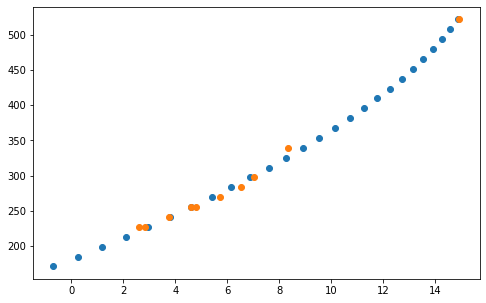

In [667]:
df = training_data.loc[training_data['unsat'] == 0]

# plt.scatter(linear_predict, pred['mz'])
plt.scatter(poly_predict, pred['mz'])
plt.scatter(df['rt'], df['mz'])
plt.gcf().set_size_inches(8, 5)

In [604]:
PolynomialFeatures(degree=2).fit_transform(training_data[:, :-1])

TypeError: '(slice(None, None, None), slice(None, -1, None))' is an invalid key

In [310]:
plot_data

,RT [min],m/z,Polarity,Area (Max.),Identification,Lipid Class,Features Found,20210729_AJ_Toh_RatBloodGlucose_ExtractionBlank.raw (F1),20210729_AJ_Toh_RatBloodGlucose_SolventBlank.raw (F2),20210729_AJ_Toh_RatBloodGlucose_T1062M_20210329_9wk_FBG_QC1.raw (F11),...,20210729_AJ_Toh_RatBloodGlucose_T1082M_20210325_8wk_RBG.raw (F30),20210729_AJ_Toh_RatBloodGlucose_T1062M_20210325_8wk_RBG.raw (F10),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210410_10wk_FBG.raw (F63),20210729_AJ_Toh_RatBloodGlucose_T1093M_20210330_8wk_RBG.raw (F48),20210729_AJ_Toh_RatBloodGlucose_T1074M_20210329_9wk_FBG.raw (F19),20210729_AJ_Toh_RatBloodGlucose_T1062M_20210401_9wk_RBG.raw (F14),20210729_AJ_Toh_RatBloodGlucose_T1101M_20210330_8wk_RBG.raw (F54),20210729_AJ_Toh_RatBloodGlucose_T1092M_20210330_8wk_RBG.raw (F42),20210729_AJ_Toh_RatBloodGlucose_T1092M_20210413_10wk_RBG.raw (F46),MS1_match_id
0,2.616,227.20168,-,22.531672,NaN,NaN,42,17.860434,17.240408,21.597794,...,20.016693,21.373446,21.577607,19.823026,20.859903,20.906383,20.894035,20.564847,19.424898,FA 14:0
2,8.295,221.15454,-,24.680330,NaN,NaN,71,20.890171,20.873965,23.745844,...,22.687847,23.059775,23.895776,22.955582,23.749319,24.547255,24.050863,23.076493,23.909383,FA 14:3
6,3.778,241.21762,-,21.750697,NaN,NaN,56,17.828027,17.303618,19.599205,...,19.459031,19.322982,19.813971,19.876975,19.468655,18.563749,19.706155,18.579041,19.471153,FA 15:0
7,4.600,255.23308,-,27.440324,NaN,NaN,56,24.061727,22.554377,26.110981,...,25.438815,25.507362,25.908342,24.961846,25.933667,24.984902,25.502003,24.691519,24.653965,FA 16:0
9,2.982,253.21753,-,23.889864,NaN,NaN,42,18.404066,17.574459,22.712675,...,21.827138,21.947401,22.857905,20.980211,22.182249,21.347271,21.653116,21.322806,20.565815,FA 16:1
11,2.241,251.20187,-,20.423988,NaN,NaN,32,14.557140,14.400662,18.991419,...,18.191395,19.359385,18.924854,17.006668,19.540284,18.301954,18.275751,17.998185,18.144343,FA 16:2
12,5.734,269.24884,-,23.200861,NaN,NaN,83,18.932086,18.401167,22.140046,...,20.997296,22.176546,22.436847,21.686342,21.690619,21.922600,21.126684,20.527649,21.619977,FA 17:0
13,4.190,267.23337,-,21.601275,NaN,NaN,64,14.665022,15.000755,20.784361,...,19.929909,20.093157,19.804507,19.974495,20.629231,19.883562,19.786675,19.298873,18.747162,FA 17:1
14,6.535,283.26453,-,28.378891,NaN,NaN,70,24.424559,23.427917,26.945808,...,27.269514,27.341674,27.418138,27.037556,27.342000,27.043968,27.432989,26.880365,26.621112,FA 18:0
17,5.122,281.24866,-,28.815355,NaN,NaN,100,23.224942,20.841370,27.878122,...,26.297485,27.213588,27.680709,25.376062,27.694150,25.974079,26.738354,25.758841,25.172720,FA 18:1


In [191]:
df['rt_norm'] = (df['RT [min]'] - df['RT [min]'].mean())/df['RT [min]'].std()
df['rt_norm']

0    -0.631249
1    -0.586962
2    -0.400257
3    -0.362730
4    -0.180687
5    -0.538712
6    -0.500719
7    -0.876692
8    -0.827277
9    -1.238214
10   -0.063443
11    0.031657
12   -0.152483
13   -0.441980
14   -0.407483
15   -0.681130
16   -0.602346
17   -0.628219
18   -0.587195
19   -0.955943
20   -1.178776
21   -0.987643
22    0.238175
23   -0.180920
24   -0.538479
25   -0.538479
26   -0.501185
27   -0.859210
28   -0.814923
29   -0.872496
30   -0.827277
31    0.345396
32    0.465204
33   -0.430792
34   -0.903497
35    0.586643
36    0.722068
37   -0.154814
38    0.287590
39    0.984760
40    0.495039
41    0.171977
42   -0.688822
43   -0.641039
44    0.460542
45   -0.489997
46   -0.837766
47    1.225075
48   -0.329165
49   -0.267163
50   -0.586962
51    2.534106
52    2.696336
53    0.837914
54    0.995016
55    2.168155
56    2.293790
57    2.500774
58    0.958421
59    2.294490
Name: rt_norm, dtype: float64